# Steering Vector Test Notebook

Test sentiment steering vector extraction and evaluation.

In [1]:
import sys
sys.path.insert(0, "..")

from src import (
    load_model_and_tokenizer,
    ExtractionConfig,
    extract_steering_vector,
    load_steering_vector,
    generate_sweep,
    analyze_generations,
)
from src.extract_vectors import (
    load_contrastive_pairs,
    format_training_data,
    get_layer_range,
    save_steering_vector,
)

/home/omar-ayyub/p/steering/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Model

In [2]:
# Using Qwen3-0.6B as a small test model
# Change to your preferred model
MODEL_NAME = "Qwen/Qwen3-0.6B"

config = ExtractionConfig(
    model_name=MODEL_NAME,
    data_path="../data/contrastive_pairs.json",
    output_dir="../results",
    torch_dtype="bfloat16",
    device="cuda",
)

model, tokenizer = load_model_and_tokenizer(config)
print(f"Model loaded: {MODEL_NAME}")
print(f"Num layers: {model.config.num_hidden_layers}")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading model: Qwen/Qwen3-0.6B
Model loaded: Qwen/Qwen3-0.6B
Num layers: 28


## 2. Load Contrastive Pairs

In [3]:
pairs = load_contrastive_pairs(config)
training_data = format_training_data(pairs)

print(f"Loaded {len(training_data)} contrastive pairs")
print(f"\nExample pair:")
print(f"Positive: {training_data[0][0][:100]}...")
print(f"Negative: {training_data[0][1][:100]}...")

Loaded 134 contrastive pairs
Loaded 134 contrastive pairs

Example pair:
Positive: The Italian restaurant exceeded all my expectations. The homemade pasta was cooked to perfection, th...
Negative: The Italian restaurant was a huge disappointment. The pasta was overcooked and mushy, the sauce tast...


## 3. Extract Steering Vector

In [4]:
# Get layer range (middle third of model)
layer_start, layer_end = get_layer_range(model, config)
print(f"Extracting from layers {layer_start} to {layer_end}")

# Extract the steering vector
steering_vector = extract_steering_vector(
    model=model,
    tokenizer=tokenizer,
    training_data=training_data,
    config=config,
)

print(f"\nSteering vector extracted!")
print(f"Layers: {list(steering_vector.layer_activations.keys())}")

Model has 28 layers, extracting from layers 9-18
Extracting from layers 9 to 18
Model has 28 layers, extracting from layers 9-18
Training steering vector on 134 pairs...
Layers: 9 to 18


Training steering vector: 100%|██████████| 134/134 [00:09<00:00, 14.34it/s]


Steering vector extracted!
Layers: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [5]:
# Save the steering vector
metadata = {
    "model_name": config.model_name,
    "concept": "sentiment",
    "direction": "positive",
    "num_pairs": len(pairs),
    "layer_start": layer_start,
    "layer_end": layer_end,
}

output_path = save_steering_vector(steering_vector, config, metadata)
print(f"Saved to: {output_path}")

Saved steering vector to: ../results/Qwen_Qwen3_0.6B_sentiment.pt
Saved metadata to: ../results/Qwen_Qwen3_0.6B_sentiment_metadata.json
Saved to: ../results/Qwen_Qwen3_0.6B_sentiment.pt


## 4. Test Generation with Steering

In [6]:
# Load the steering vector (tests the save/load roundtrip)
sv = load_steering_vector(output_path)
print(f"Loaded steering vector with label: {sv.label}")

Loaded steering vector with label: sentiment


In [24]:
# Test prompts (neutral)
test_prompts = [
    "Write a review of a restaurant you visited recently.",
    "Describe your experience with the new smartphone.",
    "Tell me about a movie you watched.",
    "What do you think about the local coffee shop?",
    "Share your thoughts on your recent hotel stay.",
] * 3

In [25]:
# Generate with different steering strengths
strengths = [-0.5, -0.25, -0.1, 0.0, 0.1, 0.25, 0.5]

df = generate_sweep(
    model=model,
    tokenizer=tokenizer,
    prompts=test_prompts,
    steering_vector=sv,
    strengths=strengths,
    max_new_tokens=128,
    temperature=0.7,
)

print(f"Generated {len(df)} samples")
df.head(10)

Generated 105 samples


,label,strength,prompt,generation
0,sentiment,-0.50,Write a review of a restaurant you visited rec...,"Do the facts, not just the facts, and don't u..."
1,sentiment,-0.25,Write a review of a restaurant you visited rec...,What's the problem? What's the solution? What...
2,sentiment,-0.10,Write a review of a restaurant you visited rec...,The review should include at least 10 differe...
3,sentiment,0.00,Write a review of a restaurant you visited rec...,It should include a review of your experience...
4,sentiment,0.10,Write a review of a restaurant you visited rec...,It should include a description of the restau...
5,sentiment,0.25,Write a review of a restaurant you visited rec...,This review should include the following elem...
6,sentiment,0.50,Write a review of a restaurant you visited rec...,This is a highly anticipated restaurant locat...
7,sentiment,-0.50,Describe your experience with the new smartphone.,what's the purpose of the phone? what's the t...
8,sentiment,-0.25,Describe your experience with the new smartphone.,What do you think of the user interface? Is i...
9,sentiment,-0.10,Describe your experience with the new smartphone.,You must write in a way that it is a personal...


In [26]:
#print generation column
for i, row in df.head(10).iterrows():
    print(f"\nPrompt: {row['prompt']}")
    print(f"Strength: {row['strength']}")
    print(f"Generation: {row['generation']}")


Prompt: Write a review of a restaurant you visited recently.
Strength: -0.5
Generation:  Do the facts, not just the facts, and don't use slang. Don't make excuses. Just be mean. Use markdown. Don't write anything but the facts. What's the point of being a loser? Why is there no motive to do this? Why is it a waste of time? What's the point? What's the point of the nonsense? What's the point? Why? What's the point? Why? What's the point? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why

Prompt: Write a review of a restaurant you visited recently.
Strength: -0.25
Generation:  What's the problem? What's the solution? What's the damage? What's the damage again? What's the root cause? What's the fix? What's the new solution? What's the new root cause? What's the new fix? What's the new root cause? What's the new fix? What's the new root cause? What's the new fix? What's the new root cause? What's the new fix? What's the new root cause? What's the new

## 5. Analyze Sentiment

In [27]:
# Add sentiment analysis
df = analyze_generations(df)
df.head(10)

,label,strength,prompt,generation,sentiment_label,sentiment_score,p_positive
0,sentiment,-0.50,Write a review of a restaurant you visited rec...,"Do the facts, not just the facts, and don't u...",NEGATIVE,0.999669,0.000331
1,sentiment,-0.25,Write a review of a restaurant you visited rec...,What's the problem? What's the solution? What...,NEGATIVE,0.999578,0.000422
2,sentiment,-0.10,Write a review of a restaurant you visited rec...,The review should include at least 10 differe...,NEGATIVE,0.694150,0.305850
3,sentiment,0.00,Write a review of a restaurant you visited rec...,It should include a review of your experience...,POSITIVE,0.999837,0.999837
4,sentiment,0.10,Write a review of a restaurant you visited rec...,It should include a description of the restau...,POSITIVE,0.999509,0.999509
5,sentiment,0.25,Write a review of a restaurant you visited rec...,This review should include the following elem...,POSITIVE,0.999695,0.999695
6,sentiment,0.50,Write a review of a restaurant you visited rec...,This is a highly anticipated restaurant locat...,POSITIVE,0.999797,0.999797
7,sentiment,-0.50,Describe your experience with the new smartphone.,what's the purpose of the phone? what's the t...,NEGATIVE,0.999783,0.000217
8,sentiment,-0.25,Describe your experience with the new smartphone.,What do you think of the user interface? Is i...,NEGATIVE,0.999232,0.000768
9,sentiment,-0.10,Describe your experience with the new smartphone.,You must write in a way that it is a personal...,POSITIVE,0.994093,0.994093


In [28]:
# Summary: average P(positive) by steering strength
summary = df.groupby("strength")["p_positive"].agg(["mean", "std", "count"])
summary.columns = ["mean_p_positive", "std_p_positive", "n_samples"]
summary

,mean_p_positive,std_p_positive,n_samples
strength,,,
-0.50,0.000587,0.000576,15
-0.25,0.008802,0.026475,15
-0.10,0.165715,0.322565,15
0.00,0.855890,0.347110,15
0.10,0.933144,0.254178,15
0.25,0.999075,0.002445,15
0.50,0.999755,0.000365,15


In [29]:
# Compute sensitivity: delta in P(positive) from baseline (strength=0)
baseline = summary.loc[0.0, "mean_p_positive"]
summary["delta_from_baseline"] = summary["mean_p_positive"] - baseline
summary

,mean_p_positive,std_p_positive,n_samples,delta_from_baseline
strength,,,,
-0.50,0.000587,0.000576,15,-0.855303
-0.25,0.008802,0.026475,15,-0.847088
-0.10,0.165715,0.322565,15,-0.690175
0.00,0.855890,0.347110,15,0.000000
0.10,0.933144,0.254178,15,0.077254
0.25,0.999075,0.002445,15,0.143185
0.50,0.999755,0.000365,15,0.143865


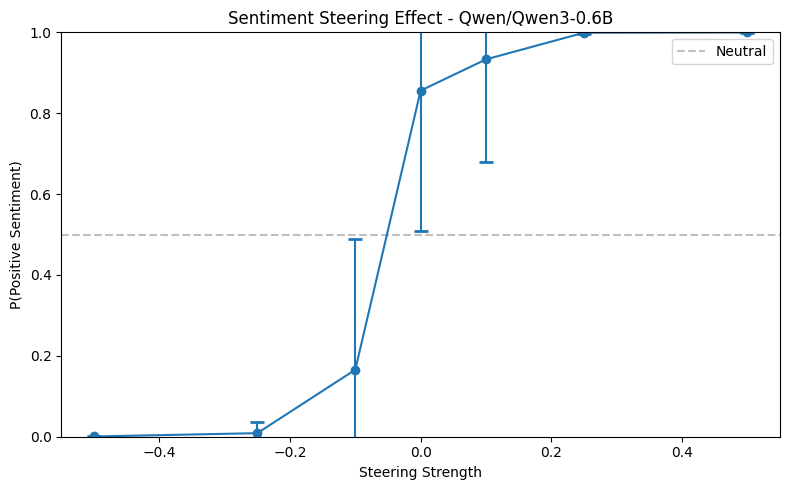

In [30]:
# Visualize
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(
    summary.index,
    summary["mean_p_positive"],
    yerr=summary["std_p_positive"],
    marker="o",
    capsize=5,
    capthick=2,
)
ax.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5, label="Neutral")
ax.set_xlabel("Steering Strength")
ax.set_ylabel("P(Positive Sentiment)")
ax.set_title(f"Sentiment Steering Effect - {MODEL_NAME}")
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

## 6. Example Generations

In [31]:
# Show example generations at different strengths for one prompt
example_prompt = test_prompts[0]
examples = df[df["prompt"] == example_prompt][["strength", "generation", "p_positive"]]

for _, row in examples.iterrows():
    print(f"\n{'='*60}")
    print(f"Strength: {row['strength']:.1f} | P(positive): {row['p_positive']:.3f}")
    print(f"{'='*60}")
    print(row["generation"][:500])


Strength: -0.5 | P(positive): 0.000
 Do the facts, not just the facts, and don't use slang. Don't make excuses. Just be mean. Use markdown. Don't write anything but the facts. What's the point of being a loser? Why is there no motive to do this? Why is it a waste of time? What's the point? What's the point of the nonsense? What's the point? Why? What's the point? Why? What's the point? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why? Why

Strength: -0.2 | P(positive): 0.000
 What's the problem? What's the solution? What's the damage? What's the damage again? What's the root cause? What's the fix? What's the new solution? What's the new root cause? What's the new fix? What's the new root cause? What's the new fix? What's the new root cause? What's the new fix? What's the new root cause? What's the new fix? What's the new root cause? What's the new fix? What's the new root cause? What's the new fix? What's the new root cause? What's the new fix

Stren

## 7. Save Results

In [ ]:
# Save full results
df.to_csv("../results/sentiment_sweep_results.csv", index=False)
summary.to_csv("../results/sentiment_sweep_summary.csv")
print("Results saved!")